In [1]:
# create datacard for 2 tag

import ROOT as rt
import csv
import re
import sys
import collections
import os

from collections import OrderedDict
import uproot
import pandas as pd

import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
sys.path.append('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/python/')
from helper import make_datacard_2sig, make_datacard_2tag, weight_calc
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from helper_functions import deltaR, deltaPhi

import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 0


print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
fpath =OrderedDict()
tree = OrderedDict()
mass = [15, 40, 55]

prod = ['ggH']
decay = 'bbbb'


# prod = ['ggH','VBFH','ZH', 'WH', 'ttH_H','ggZH']
# prod = ['ggH']
# decay = 'bbbb'

# decay = '4Tau'


mass = [15, 40, 55]
if not decay == 'bbbb': mass = [7, 15, 40, 55]

OLD_CTAU = np.array([100, 1000, 10000, 100000])#in mm

ntupler_version = 'V1p17/'

data_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/V1p17/Data2018/v5/v138/normalized/'
# fpath['data'] = '/storage/af/user/christiw/login-1/christiw/LLP/displacedJetMuonAnalyzer/csc/V1p17//Data2018//v5/v127//normalized/Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'

fpath['data'] = data_path + 'Run2_displacedJetMuonNtupler_V1p17_Data2016_Data2017_Data2018-HighMET_goodLumi.root'
mc_path = {}

analyzer_version = 'v1/v155/'




for m in mass:
    for ct in OLD_CTAU:
        for y in ['MC_Summer16', 'MC_Fall17', 'MC_Fall18']:
            mc_path = '/storage/af/group/phys_exotica/delayedjets/displacedJetMuonAnalyzer/csc/'+ntupler_version+'/'+y+'/'+analyzer_version+'/normalized/'
            key = 'MC_ggH_'+str(m)+'_'+str(ct)+'_'+y    
            if 'MC_Summer16' in y: 
                fpath[key] = mc_path+'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCUETP8M1_13TeV-powheg-pythia8_35920pb_weighted.root'
            elif 'MC_Fall17' in y:
                fpath[key] = mc_path+'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_41530pb_weighted.root'
            else: 
                fpath[key] = mc_path+'ggH_HToSSTo'+decay+'_MH-125_MS-'+str(m)+'_ctau-'+str(ct)+'_TuneCP5_13TeV-powheg-pythia8_59740pb_weighted.root'





NEvents = {}
NEvents_genweight = {}
for k,v in fpath.items():
    root_dir = uproot.open(v) 
    if not root_dir: 
        print(k, "zombie")
        continue
    tree[k] = root_dir['MuonSystem']
    NEvents[k] = root_dir['NEvents'][1]
    
    w = tree[k]["weight"].array()
    if not 'data' in k: 
        print(k, root_dir['NEvents']._fEntries)
        


root_dir = uproot.open('/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/HiggsPtWeights/ZHToggZH_HiggsPtReweight.root') 
h_reweight = root_dir['higgsPthiggsEta']

MC_ggH_15_100_MC_Summer16 2012998.0
MC_ggH_15_100_MC_Fall17 1983000.0
MC_ggH_15_100_MC_Fall18 2989000.0
MC_ggH_15_1000_MC_Summer16 1979000.0
MC_ggH_15_1000_MC_Fall17 1957000.0
MC_ggH_15_1000_MC_Fall18 2988000.0
MC_ggH_15_10000_MC_Summer16 2056000.0
MC_ggH_15_10000_MC_Fall17 2060000.0
MC_ggH_15_10000_MC_Fall18 3041000.0
MC_ggH_15_100000_MC_Summer16 2024999.0
MC_ggH_15_100000_MC_Fall17 1938999.0
MC_ggH_15_100000_MC_Fall18 3112000.0
MC_ggH_40_100_MC_Summer16 2023381.0
MC_ggH_40_100_MC_Fall17 1954000.0
MC_ggH_40_100_MC_Fall18 2954000.0
MC_ggH_40_1000_MC_Summer16 2018000.0
MC_ggH_40_1000_MC_Fall17 1935000.0
MC_ggH_40_1000_MC_Fall18 2963000.0
MC_ggH_40_10000_MC_Summer16 1966999.0
MC_ggH_40_10000_MC_Fall17 1992999.0
MC_ggH_40_10000_MC_Fall18 3097000.0
MC_ggH_40_100000_MC_Summer16 2124483.0
MC_ggH_40_100000_MC_Fall17 1997000.0
MC_ggH_40_100000_MC_Fall18 3165000.0
MC_ggH_55_100_MC_Summer16 1926999.0
MC_ggH_55_100_MC_Fall17 2005000.0
MC_ggH_55_100_MC_Fall18 2959000.0
MC_ggH_55_1000_MC_Summer16 2

# nCsc with different hit vetoing

In [3]:

jetPt_cut = 50

weight = {}
nhits1 = {}
nhits2 = {}
sel_ev = {}
cond = {}
ggZH_weight = {}
higgsEta = {}
higgsPt = {}
nDtWheels = {}
nDtStations = {}
nDTRechitsNoiseSec8 = {}
nDTRechitsNoiseSec9 = {}
nDTRechitsNoiseSec10 = {}
dtRechitClusterDphi = {}
dtRechitClusterMaxStation ={}
dtRechitClusterMaxStationRatio = {}
dtRechitClusterJetVetoPt = {}

cscRechitClusterMe11Ratio = {}
cscRechitClusterMe12Ratio = {}
cscRechitClusterMe11 = {}
cscRechitClusterNStation = {}
cscRechitClusterEta = {}
cscRechitClusterMaxChamber = {}
cosmicTwoLegCluster1Size = {}
cosmicTwoLegCluster2Size = {}
cscRechitClusterJetVetoPt = {}
cscRechitClusterTimeSpread = {}

cosmicTwoLegClusterChi2Reduced = {}
cosmicTwoLegCluster2NStation = {}
cosmicTwoLegCluster1NStation = {}
cosmicTwoLegCluster2Index = {}
cosmicTwoLegCluster1Index = {}
nCosmic = {}
cluster_index = ''
addNoiseFlag = 1
# 0: 2 CSC; 1: 2DT; 2: csc+dt
category = 2


for k in list(tree.keys())+['data_oot_sr', 'data_oot_vr', 'data_intime_vr','data_intime_sr']:
    if 'data' in k:continue
########### SELECTION: CLUSTERS ############
    if 'data' in k: T = tree['data']
    else: T = tree[k]

                
    sel_csccluster = np.logical_and(T.array('cscRechitCluster' + cluster_index + '_match_gLLP_minDeltaR')<0.4, T.array('cscRechitCluster' + cluster_index + '_match_gLLP'))
    

#     sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'TimeSpread')<20)

    sel_csccluster = np.logical_and(sel_csccluster, np.abs(T.array('cscRechitCluster' + cluster_index + 'MetEENoise_dPhi'))<1.2)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')<30)
    sel_csccluster = np.logical_and(sel_csccluster, T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')<1)
    
    sel_csccluster = np.logical_and(sel_csccluster, np.logical_and(T.array('cscRechitCluster' + cluster_index + 'TimeTotal')+0.51 < 12.5, \
                                                                         T.array('cscRechitCluster' + cluster_index + 'TimeTotal')+0.51 > -5))
    sel_dtcluster = np.logical_and(np.abs(T.array('dtRechitCluster_match_gLLP_minDeltaR'))<0.4, np.abs(T.array('dtRechitCluster_match_gLLP')))
#     sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster_match_gLLP_dt'))
#     sel_dtcluster = T.array('dtRechitCluster_match_RPChits_dPhi0p5')>=0
    sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitCluster_match_RPChits_dPhi0p5')>=0)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterMetEENoise_dPhi')) < 1)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.abs(T.array('dtRechitClusterJetVetoPt')) < 50)
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(T.array('dtRechitClusterMaxStation')==1, T.array('dtRechitClusterMaxStationRatio')>0.9)))
    if addNoiseFlag: sel_dtcluster = np.logical_and(sel_dtcluster, (T.array('dtRechitClusterSize')+T.array('dtRechitClusterNoiseHit')) >= 50)
    else: sel_dtcluster = np.logical_and(sel_dtcluster, T.array('dtRechitClusterSize') >= 50)




    ###################### cosmic muon veto #############
    sel_cosmic = np.logical_and(T.array('dtRechitClusterNOppositeSegStation1')>0, T.array('dtRechitClusterNOppositeSegStation2')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation3')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation4')>0)
    sel_cosmic = np.logical_and(sel_cosmic, T.array('dtRechitClusterNOppositeSegStation1')+T.array('dtRechitClusterNOppositeSegStation2')+\
                               T.array('dtRechitClusterNOppositeSegStation3')+T.array('dtRechitClusterNOppositeSegStation4')>=6)
    nstation = (T.array('dtRechitClusterNSegmentStation1')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation2')>1).astype(int)\
    +(T.array('dtRechitClusterNSegmentStation3')>1).astype(int)+(T.array('dtRechitClusterNSegmentStation4')>1).astype(int)
    
    sel_dtcluster = np.logical_and(sel_dtcluster, np.logical_not(np.logical_and(nstation>=3, sel_cosmic)))
    
########### SELECTION: JETS ############
    
    sel_jet = np.logical_and(T.array('jetPt') > 30, np.abs(T.array('jetEta')) < 2.4 )
    sel_jet = np.logical_and(T.array('jetTightPassId'), sel_jet)


            
########### SELECTION: NOISE IN DT ############
    
    spike = np.logical_and( T.array('nDTRechitsSector')[:,0,0,7]>50,  T.array('nDTRechitsSector')[:,0,0,7]+T.array('nDTRechitsSector')[:,0,0,8]+T.array('nDTRechitsSector')[:,0,0,9]>120)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,8]>25)
    spike = np.logical_and(spike, T.array('nDTRechitsSector')[:,0,0,9]>10)

    
    
########### SELECTION: EVENTS ############

    sel_ev[k] = T.array('METNoMuTrigger')
    sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('metEENoise') >= 200)
#     sel_ev[k]  = np.logical_and(sel_ev[k], T.array('category') == 0)
#     sel_ev[k] = np.logical_and(sel_ev[k] ,T.array('nLeptons') == 0)
    sel_ev[k] = np.logical_and(sel_ev[k] , sel_jet.sum()>=1)
    sel_ev[k] = np.logical_and(sel_ev[k], (T.array('nDtRings')+T.array('nCscRings'))<10)
    sel_ev[k] = np.logical_and(sel_ev[k],T.array('Flag2_all'))
    sel_ev[k] = np.logical_and(sel_ev[k] , np.logical_not(spike))

########### BRANCHES ############


                     
                            
    if category == 0:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 0)

        index = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_csccluster][sel_ev[k]][:,:2]
        cond[k] = np.logical_not(index[:,0]==index[:,1])
        cluster1 = T.array('evtNum')[sel_ev[k]]%2
        cluster1 = np.column_stack((cluster1,np.logical_not(cluster1)))
        cluster1 = np.argwhere(cluster1)[:,1]
        cluster2 = 1-cluster1
        nhits1[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster1]
        nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster2]
        cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]]
        cscRechitClusterMe12Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me12Ratio')[sel_csccluster][sel_ev[k]]
        cscRechitClusterJetVetoPt[k] =  T.array('cscRechitCluster' + cluster_index + 'JetVetoPt')[sel_csccluster][sel_ev[k]]
        cscRechitClusterMaxChamber[k] = T.array('cscRechitCluster' + cluster_index + 'MaxChamber')[sel_csccluster][sel_ev[k]]
        cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]]
        cscRechitClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]]


    elif category == 1:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum()== 2)
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum()== 0)
        index = T.array('dtRechitCluster' + cluster_index + '_match_gLLP_index')[sel_dtcluster][sel_ev[k]][:,:2]
        cond[k] = np.logical_not(index[:,0]==index[:,1])        
        cluster1 = T.array('evtNum')[sel_ev[k]]%2
        cluster1 = np.column_stack((cluster1,np.logical_not(cluster1)))
        cluster1 = np.argwhere(cluster1)[:,1]
        cluster2 = 1-cluster1

        if addNoiseFlag:
            nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster1]
            nhits2[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster2]
        else:
            nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster1]
            nhits2[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster2]
        dtRechitClusterDphi[k] = deltaPhi(T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster1], \
                                         T.array('dtRechitClusterPhi')[sel_dtcluster][sel_ev[k]][range(np.count_nonzero(sel_ev[k])),cluster2])
        dtRechitClusterMaxStation[k] =  T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]]
        dtRechitClusterMaxStationRatio[k] =  T.array('dtRechitClusterMaxStationRatio')[sel_dtcluster][sel_ev[k]]
        dtRechitClusterJetVetoPt[k] =  T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]]



        
    elif category == 2:
        sel_ev[k]  = np.logical_and(sel_ev[k],sel_csccluster.sum() >= 1)
#         sel_ev[k]  = np.logical_and(sel_ev[k],sel_dtcluster.sum() == 1)
#         dt_index = T.array('dtRechitCluster' + cluster_index + '_match_gLLP_index')[sel_dtcluster][sel_ev[k]][:,0]
        csc_index = T.array('cscRechitCluster' + cluster_index + '_match_gLLP_index')[sel_csccluster][sel_ev[k]][:,0]
#         cond[k] = np.logical_not(dt_index == csc_index)
        
#         if addNoiseFlag:
#             nhits1[k] =  (T.array('dtRechitClusterNoiseHit')+T.array('dtRechitClusterSize'))[sel_dtcluster][sel_ev[k]][:,0]
#         else:
#             nhits1[k] =  T.array('dtRechitClusterSize')[sel_dtcluster][sel_ev[k]][:,0]
#         nhits2[k] =  T.array('cscRechitCluster' + cluster_index + 'Size')[sel_csccluster][sel_ev[k]][:,0]
        
#         dtRechitClusterMaxStation[k] =  T.array('dtRechitClusterMaxStation')[sel_dtcluster][sel_ev[k]][:,0]
#         dtRechitClusterMaxStationRatio[k] =  T.array('dtRechitClusterMaxStationRatio')[sel_dtcluster][sel_ev[k]][:,0]
        cscRechitClusterMe11Ratio[k] =  T.array('cscRechitCluster' + cluster_index + 'Me11Ratio')[sel_csccluster][sel_ev[k]][:,0]

        cscRechitClusterTimeSpread[k] =  T.array('cscRechitCluster' + cluster_index + 'TimeSpread')[sel_csccluster][sel_ev[k]][:,0]

        cscRechitClusterMe11[k] = (T.array('cscRechitCluster' + cluster_index + 'NRechitChamberPlus11') + T.array('cscRechitCluster' + cluster_index + 'NRechitChamberMinus11'))[sel_csccluster][sel_ev[k]][:,0] 
        cscRechitClusterNStation[k] =  T.array('cscRechitCluster' + cluster_index + 'NStation10')[sel_csccluster][sel_ev[k]][:,0]
        cscRechitClusterEta[k] =  T.array('cscRechitCluster' + cluster_index + 'Eta')[sel_csccluster][sel_ev[k]][:,0]
#         dtRechitClusterJetVetoPt[k] =  T.array('dtRechitClusterJetVetoPt')[sel_dtcluster][sel_ev[k]][:,0]

    else:
        assert(False)

    
    higgsPt[k] = T.array('gHiggsPt')[sel_ev[k]]
    higgsEta[k] = T.array('gHiggsEta')[sel_ev[k]]

    ggZH_weight[k]=h_reweight.values[np.argmax(h_reweight.edges[0]>higgsPt[k][:,None],axis=1)-1, np.argmax(h_reweight.edges[1]>np.abs(higgsEta[k])[:,None],axis=1)-1]
    
#     if 'ggH' in k: weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev[k]]


    if 'ggH' in k: weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('higgsPtWeight')*T.array('metSF'))[sel_ev[k]]
    else:weight[k] = (T.array('weight')*T.array('pileupWeight')*T.array('metSF'))[sel_ev[k]]
    if 'ggZH' in k: weight[k] *= ggZH_weight[k]
    
    # corrections: 6% muon, 1.5% jet, 3.3% rechits

#     if category == 0:signal_correction = (1-0.015)**2
#     elif category == 1:signal_correction = 1
#     elif category == 2:signal_correction = (1-0.015)
#     else: assert(False)


MC_ggH_15_10000_MC_Summer16 0.9912560266774011 0.0035599403133640866 0.0035599403133640866
MC_ggH_15_10000_MC_Fall17 0.9668181763197559 0.007794093935859032 0.007794093935859032
MC_ggH_15_10000_MC_Fall18 0.9845494801073816 0.004127180321951267 0.004127180321951267


Warning in <TROOT::Append>: Replacing existing TH1: MC_ggH_15_10000_MC_Summer16 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_ggH_15_10000_MC_Summer16 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning in <TEfficiency::GetEfficiencyErrorUp>: frequentist confidence intervals for weights are only supported by the normal approximation
Info in <TEfficiency::GetEfficiencyErrorUp>: setting statistic option to kFNormal
Warning in <TROOT::Append>: Replacing existing TH1: MC_ggH_15_10000_MC_Fall17 (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: MC_ggH_15_10000_MC_Fall17 (Potential memory leak).
Info in <TEfficiency::TEfficiency>: given histograms are filled with weights
Info in <TROOT::TEfficiency::SetUseWeightedEvents>: Handle weighted events for computing efficiency
Warning 

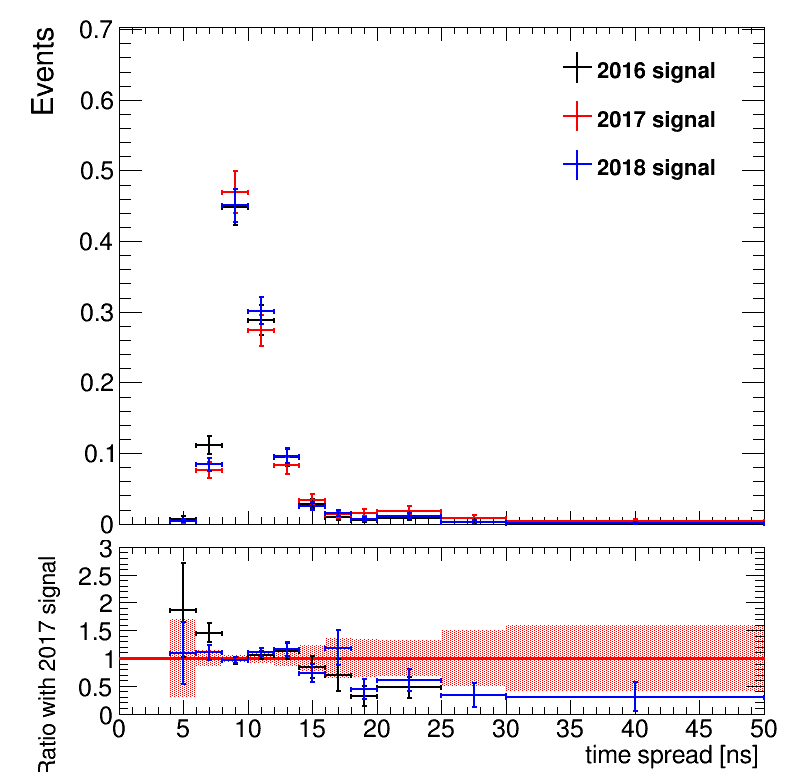

In [15]:
import importlib
importlib.reload(sys.modules['histo_utilities'])
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot, make_ratio_pEff

rt.gStyle.SetOptFit(1011)
c = rt.TCanvas('c','c', 800, 800)
h = {}
i = 0
key = 'MC_ggH_15_10000_'
for k in tree.keys():
    if not key in k:continue
    h[k] = create_TH1D( cscRechitClusterTimeSpread[k], axis_title=['time spread [ns]', 'Events'], name=k, binning=list(np.arange(0,20,2))+list(np.arange(20,35,5))+[50], weights = weight[k])
    h[k].Scale(1./h[k].Integral())
    h[k].SetLineColor(std_color_list[i])
    h[k].Draw('hist same')
    
    hm = create_TH1D( np.ones((np.count_nonzero(cscRechitClusterTimeSpread[k]<20),)), axis_title=['time spread [ns]', 'Events'], name=k, binning=[1,0,2], weights = weight[k][cscRechitClusterTimeSpread[k]<20])

    hb = create_TH1D( np.ones((len(cscRechitClusterTimeSpread[k]),)), axis_title=['time spread [ns]', 'Events'], name=k, binning=[1,0,2], weights = weight[k])
    eff = rt.TEfficiency(hm, hb)
    print(k,  eff.GetEfficiency(1),eff.GetEfficiencyErrorUp(1),eff.GetEfficiencyErrorLow(1))
    i+=1
c = make_ratio_plot([h[key + 'MC_Summer16'],h[key + 'MC_Fall17'],h[key + 'MC_Fall18']], fit = False, logy=0, in_tags = ['2016 signal', '2017 signal', '2018 signal'], \
                        ratio_bounds = [0,3], ratio_index = 1, draw_opt = ['E1','E2','E1']) 
c.Draw()

# file_name = dir_name+region+'_'+names[j]+"_withRatio_muonPt"+str(muonPt)+"_"+m1+'_'+m2
# print(file_name)
# if norm: file_name += "_norm"
# c.SaveAs(file_name+".png")
# c.SaveAs(file_name+".C")

